CONFIGURAÇÕES INICIAIS E CARREGAR O DATASET

In [1]:
import tensorflow as tf
gpus =tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#trazer datasets
import tensorflow_datasets as tfds
#import matplotlib para vizualizar imagens
from matplotlib import pyplot as plt

ds=tfds.load('kmnist',split='train')

In [ ]:
ds.as_numpy_iterator().next()

VIZUALIZAR E TRATAR IMAGENS

In [4]:
#Ver imagens e construir dataset
import numpy as np

In [5]:
dataiterator = ds.as_numpy_iterator()

In [ ]:
#'retira' dados do pipeline
dataiterator.next()

In [7]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

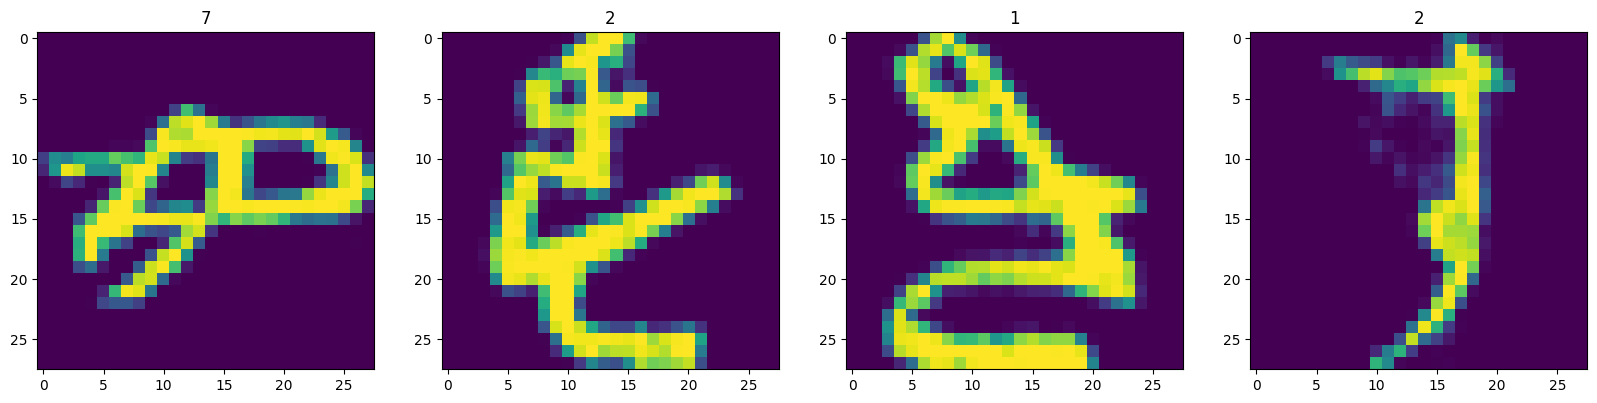

In [8]:
#plot images
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    #pega um novo batch
    batch=dataiterator.next()
    #plota a imagem
    ax[idx].imshow(np.squeeze(batch['image']))
    #adiciona a label
    ax[idx].title.set_text(batch['label'])

In [9]:
#transforma a escla e retorna a imagem ---- dados entre 0 e 1 melhoram a rede neural e diminuem o tempo de treino
def scales_images(data):
    image=data['image']/255
    return image

In [10]:
'''Construir o banco de dados
é necessário mapear, fazer cache, shuffle, batch e prefetch '''

ds = ds.map(scales_images) #passa o dataset pela função de scalling
#data augmentation seria feito aqui
ds = ds.cache() 
ds = ds.shuffle(60000) #embaralha
ds = ds.batch(128) #forma batches de 128 imagens
ds = ds.prefetch(64) #reduz a probabilidade de bottleneck

In [11]:
ds.as_numpy_iterator().next().shape #formato é de 128 (imagens), 28x28 pixels e 1 canal (cor, grascaled, se fosse rgb seriam 3 canais)

(128, 28, 28, 1)

CONTRUÇÃO DOS MODELOS TANTO O GENERATOR QUANTO O DISCRIMINATOR

In [12]:
#importar bibliotecas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [13]:
# Construir o generator
def build_generator():
    model = Sequential()

    # recebe valores aleatorios e transforma em 7*7*128 e começa a montar uma imagem
    model.add(Dense(7*7*128,input_dim=128)) # input layer, 7*7*128 porque serão 128 valores(imagens) que serão convertidos em uma área de 7*7
    model.add(LeakyReLU(0.2)) # consegue atender a situações não-lineares -- Não possui parametros (será possível ver no summary)
    model.add(Reshape((7,7,128)))# "converte" em uma imagem 7*7 com 128 canais -- shape = (7,7,128), no final será (28,28,1)

    # Upsampling block 1
    model.add(UpSampling2D()) # Dobra o tamanho --> shape = (14,14,128) -- Também não possui parametros
    model.add(Conv2D(128,5,padding='same')) # padding='same' impede que o formato da imagem diminua
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())  # Shape = (28,28,128)
    model.add(Conv2D(128,5,padding='same')) 
    model.add(LeakyReLU(0.2))

    # Downsampling block 1
    model.add(Conv2D(128,4,padding='same')) # Apenas adiciona parametros
    model.add(LeakyReLU(0.2))

    # Dowsampling block 2
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    # Ultima camada com o resultado
    model.add(Conv2D(1,4,padding='same',activation='sigmoid'))
    
    return model

In [14]:
generator = build_generator()

In [15]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [16]:
imgs = generator.predict(np.random.randn(4,128,1))
imgs

1/1 [==============================] - 14s 14s/step


array([[[[0.5064109 ],
         [0.5054443 ],
         [0.49850667],
         ...,
         [0.50090426],
         [0.5062501 ],
         [0.5043996 ]],

        [[0.5075286 ],
         [0.504985  ],
         [0.503167  ],
         ...,
         [0.49714288],
         [0.5090398 ],
         [0.5053843 ]],

        [[0.51078594],
         [0.5075161 ],
         [0.50162315],
         ...,
         [0.5022055 ],
         [0.5079985 ],
         [0.50965166]],

        ...,

        [[0.48735484],
         [0.48806214],
         [0.48630306],
         ...,
         [0.50429404],
         [0.50127727],
         [0.50325704]],

        [[0.49179232],
         [0.49501324],
         [0.49583587],
         ...,
         [0.5033194 ],
         [0.50064075],
         [0.503584  ]],

        [[0.4968797 ],
         [0.49809912],
         [0.5017956 ],
         ...,
         [0.50187993],
         [0.5000954 ],
         [0.5011783 ]]],


       [[[0.49735203],
         [0.5007247 ],
         [0.49

In [17]:
imgs.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 17ms/step


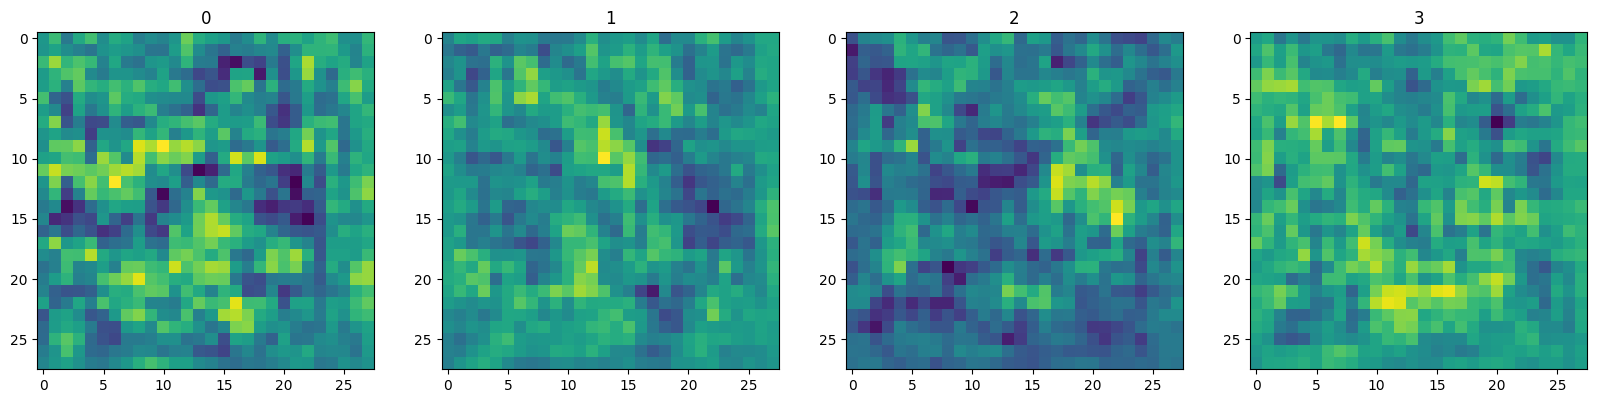

In [18]:
#plota imagens NÃO TREINADAS
imgs = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(imgs):
    #plota a imagem
    ax[idx].imshow(np.squeeze(img))
    #adiciona a label
    ax[idx].title.set_text(idx)


In [19]:
# Construir o Discriminator

def build_discriminator():
    model = Sequential()

    # Bloco Conv 1
    model.add(Conv2D(32,5,input_shape=(28,28,1))) #input_shape igual à saída do generator
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) # precisamos dificultar o treino do discrimnator para equilibrar com o generator

    # Bloco Conv 2
    model.add(Conv2D(64,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Bloco Conv 3
    model.add(Conv2D(128,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Bloco Conv 4
    model.add(Conv2D(256,5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten e Dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid')) # classifica entre imagem falsa e verdadeira


    return model

In [20]:
discriminator = build_discriminator()

In [21]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [22]:
discriminator.predict(imgs) #0==False 1==True NÃO TREINADA

1/1 [==============================] - 0s 146ms/step


array([[0.49794543],
       [0.4980203 ],
       [0.49807933],
       [0.4979691 ]], dtype=float32)

CONSTRUÇÃO DO LOOP DE TREINO PERSONALIZADO

O problema é encontrar o equilibrio entre o treino do discriminator e do generator. Para isso, adiconaremos erros propositais no dataset do discriminator

In [23]:
#import optimizers e losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [24]:
g_opt=Adam(learning_rate=0.0001)
d_opt=Adam(learning_rate=0.00001) # mais lento que o generator
g_loss=BinaryCrossentropy()
d_loss=BinaryCrossentropy()

In [25]:
# importa modelo base para usarmos uma subclasse no treino
from tensorflow.keras.models import Model

In [26]:
class kmnistGAN(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.gen=generator
        self.disc=discriminator

    def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        self.g_opt=g_opt
        self.d_opt=d_opt
        self.g_loss=g_loss
        self.d_loss=d_loss
        
    def train_step(self,batch):
        real_images=batch
        fake_images=self.gen(tf.random.normal((128,128,1)),training=False)

        # treinar discriminator
        with tf.GradientTape() as d_tape:
            # passar imagens reais e falsas
            yhat_real = self.disc(real_images,training=True)
            yhat_fake = self.disc(fake_images,training=True)
            yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)

            # criar labels para as imagens
            y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0) # "True y values"

            # adicionar erros
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake=-0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake+=tf.concat([noise_real,noise_fake],axis=0)

            # calcular loss
            total_d_loss = self.d_loss(y_realfake,yhat_realfake)

        # aplicar backpropagation - nn aprende
        dgrad = d_tape.gradient(total_d_loss,self.disc.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad,self.disc.trainable_variables))

        # treinar generator
        with tf.GradientTape() as g_tape:
            # gerar imagens
            gen_images = self.gen(tf.random.normal((128,128,1)),training=True)

            # criar labels previstos
            predicted_labels = self.disc(gen_images,training=False)

            # calcular loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels),predicted_labels) # loss diminui quando generator consegue enganar o discriminator

        # aplicar backpropagation
        ggrad = g_tape.gradient(total_g_loss,self.gen.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad,self.gen.trainable_variables))

        return {'d_loss': total_d_loss, 'g_loss':total_g_loss}

In [27]:
kminGAN = kmnistGAN(generator,discriminator)

In [28]:
kminGAN.compile(g_opt,d_opt,g_loss,d_loss)

In [29]:
# construir callback
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [30]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3,latent_dim=128):
        self.num_img=num_img
        self.latent_dim=latent_dim

    def on_epoch_end(self,epoch,logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img,self.latent_dim,1))
        generated_images = self.model.gen(random_latent_vectors)
        generated_images*=255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images-kmnist',f'generated)img_{epoch}_{i}.png'))

In [31]:
hist = kminGAN.fit(ds,epochs=100,callbacks=[ModelMonitor()])

Epoch 1/100
469/469 [==============================] - 72s 136ms/step - d_loss: 0.4671 - g_loss: 3.1178
Epoch 2/100
469/469 [==============================] - 72s 154ms/step - d_loss: 0.2711 - g_loss: 4.8604
Epoch 3/100
469/469 [==============================] - 76s 161ms/step - d_loss: 0.4118 - g_loss: 1.8054
Epoch 4/100
469/469 [==============================] - 74s 159ms/step - d_loss: 0.2761 - g_loss: 2.5737
Epoch 5/100
469/469 [==============================] - 73s 155ms/step - d_loss: 0.2770 - g_loss: 7.2034
Epoch 6/100
469/469 [==============================] - 73s 155ms/step - d_loss: 0.2712 - g_loss: 6.8107
Epoch 7/100
469/469 [==============================] - 75s 159ms/step - d_loss: 0.2701 - g_loss: 6.1118
Epoch 8/100
469/469 [==============================] - 75s 160ms/step - d_loss: 0.2695 - g_loss: 5.6307
Epoch 9/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2691 - g_loss: 5.2443
Epoch 10/100
469/469 [==============================] - 77s 164m

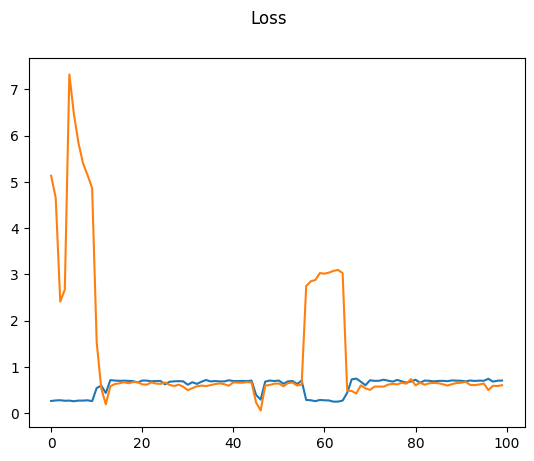

In [32]:
# performance

plt.suptitle('Loss')
plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend
plt.show()

GERAR IMAGENS COM O GENERATOR

1/1 [==============================] - 0s 21ms/step


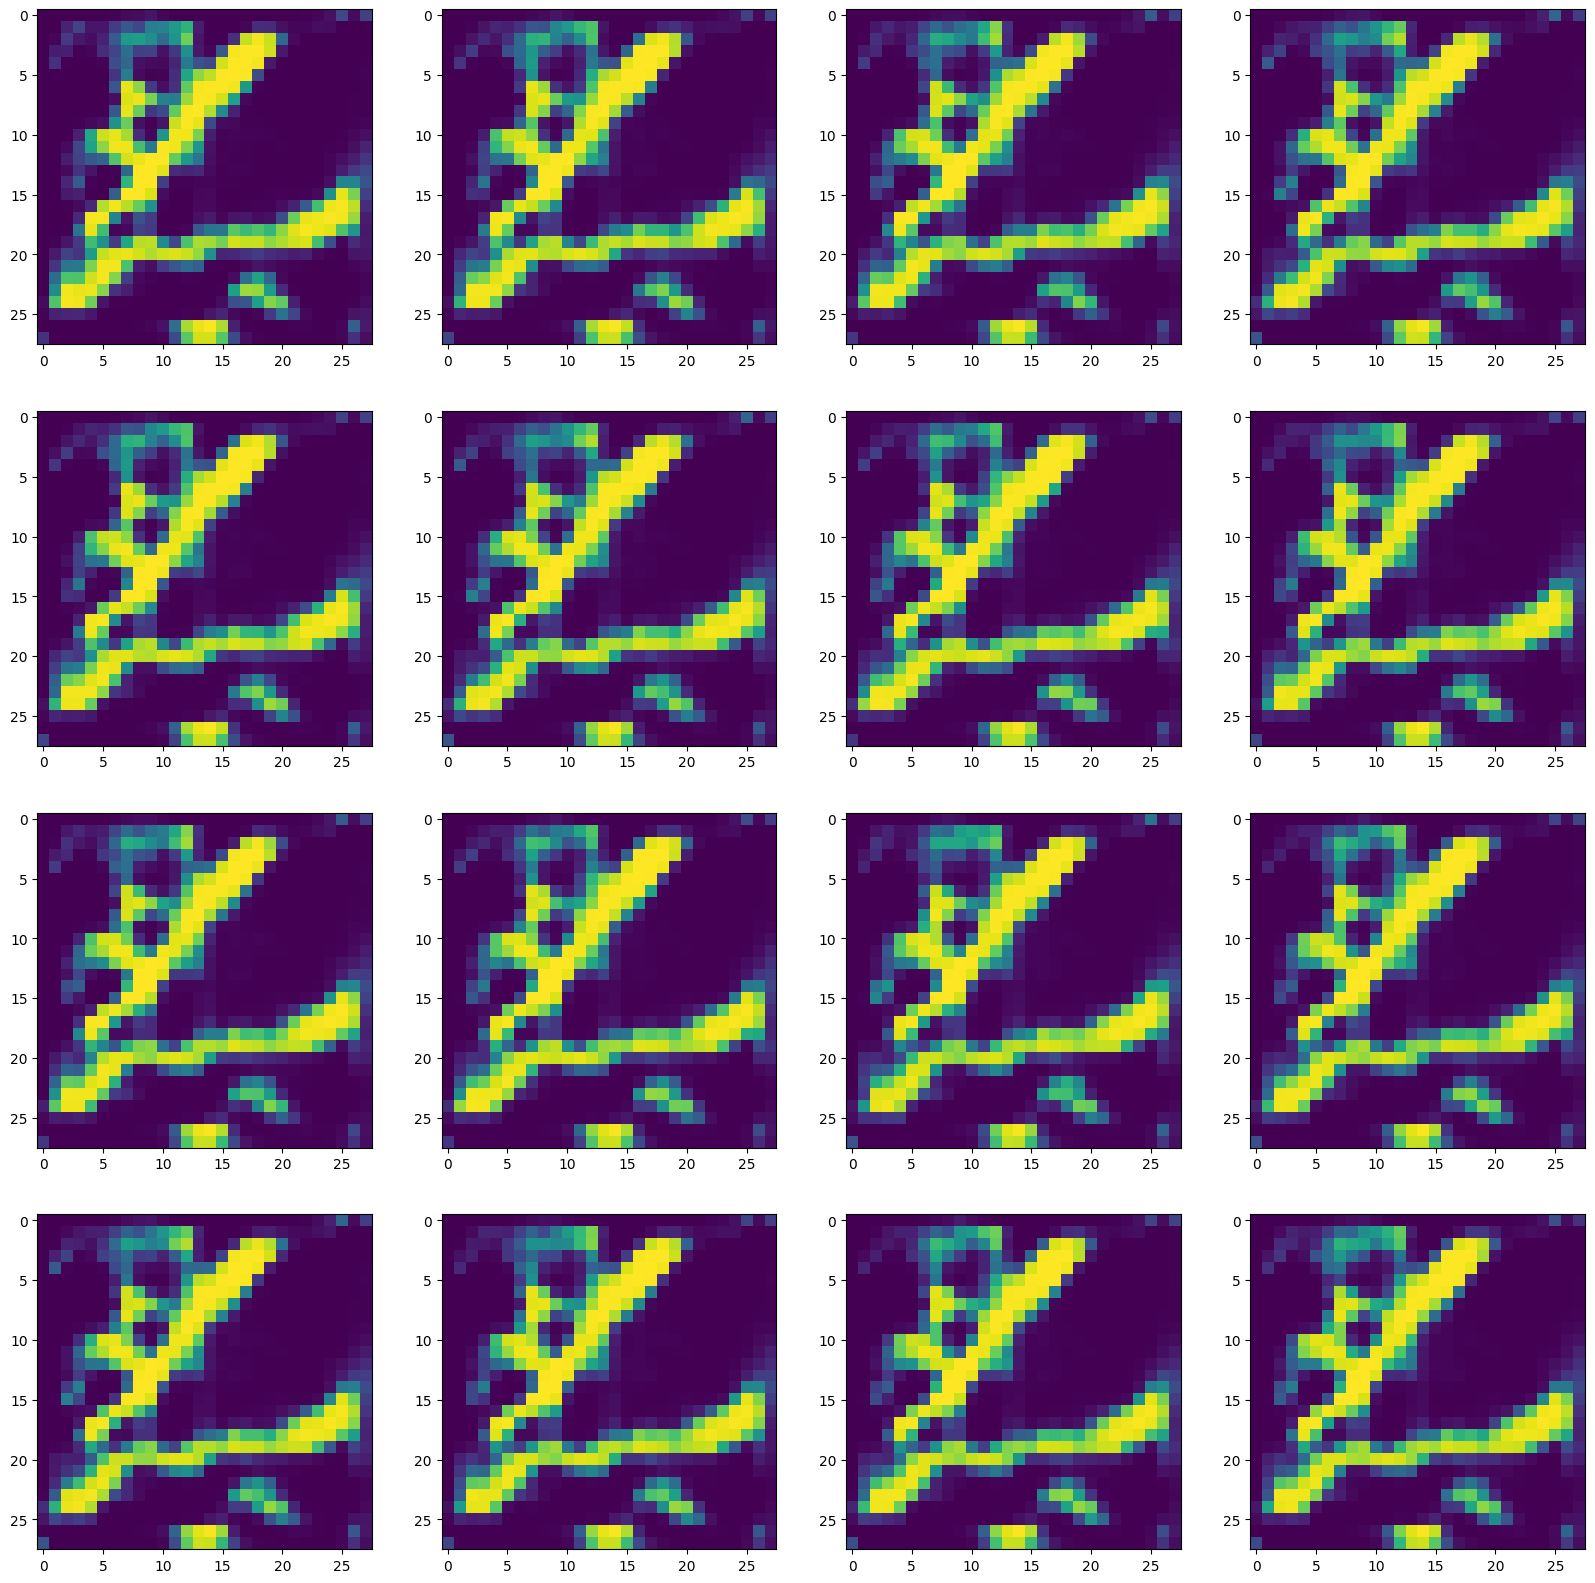

In [43]:
# Imagens TREINADAS

imgs=generator.predict(tf.random.uniform((16,128,1)))
fig, ax = plt.subplots(ncols=4,nrows=4,figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [44]:
generator.save("generator-kmnist.h5")
discriminator.save('discriminator-kmnist.h5')